<a href="https://colab.research.google.com/github/GuilhermeLoboSousa/sistemasinteligentes/blob/main/group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug Synergy Prediction

1.   Exploração inical e pré-processamento
2.   Análise não supervisionada




## Group 1
Guilherme Sousa

Joana Araújo

Karyna Lysenko

Tiago Silva

**Exploração inical e pré-processamento**

**Definition**: Synergy is a dimensionless measure of deviation of an observed drug combination response from the expected effect of non-interaction. Synergy can be calculated using different models such as the Bliss model, Highest Single Agent (HSA), Loewe additivity model and Zero Interaction Potency (ZIP). Another relevant metric is CSS which measures the drug combination sensitivity and is derived using relative IC50 values of compounds and the area under their dose-response curves.

**Impact**: Drug combination therapy offers enormous potential for expanding the use of existing drugs and in improving their efficacy. For instance, the simultaneous modulation of multiple targets can address the common mechanisms of drug resistance in the treatment of cancers. However, experimentally exploring the entire space of possible drug combinations is not a feasible task. Computational models that can predict the therapeutic potential of drug combinations can thus be immensely valuable in guiding this exploration.

**Generalization**: It is important for model predictions to be able to adapt to varying underlying biology as captured through different cell lines drawn from multiple tissues of origin. Dosage is also an important factor that can impact model generalizability.

**Product**: Small-molecule.

**Pipeline**: Activity.

Link:https://tdcommons.ai/multi_pred_tasks/drugsyn/

**Dataset Description**: A large-scale oncology screen produced by Merck & Co., where each sample consists of two compounds and a cell line. The dataset covers 583 distinct combinations, each tested against 39 human cancer cell lines derived from 7 different tissue types. Pairwise combinations were constructed from 38 diverse anticancer drugs (14 experimental and 24 approved). The synergy score is calculated by Loewe Additivity values using the batch processing mode of Combenefit. The genomic features are from ArrayExpress database (accession number: E-MTAB-3610) and was quantile normalized and summarized with Factor Analysis for Robust Microarray Summarization (FARMS). The processed data is provided by DeepSynergy.

**Task Description**: Regression. Given the gene expression of cell lines and two SMILES strings of the drug combos, predict the drug synergy level.

**Dataset Statistics**: 23,052 drug combo-cell line points, among 39 cancer cell lines and 37 drugs

# Imports

In [ ]:
pip install PyTDC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 21.2 MB/s eta 0:00:00
  Created wheel for PyTDC: filename=PyTDC-0.4.1-py3-none-any.whl size=140644 sha256=b5b770a883b7832cf8400e1bdd0c5c2df4a82e3e175b9e10df6e5e650211c3d7
  Stored in directory: /root/.cache/pip/wheels/14/b7/b8/9d9e1442129743359b0507234ccc0beb67b47173faccd57d54
Successfully built PyTDC


**Imports**

In [ ]:
from tdc.multi_pred import DrugSyn
import pandas as pd

from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import Chem, RDLogger

import numpy as np
from rdkit.Chem.GraphDescriptors import Ipc
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors

from collections import OrderedDict

from rdkit.Chem import AllChem

from sklearn.preprocessing import StandardScaler



**Carregar o dataset**

In [ ]:
data = DrugSyn(name = "OncoPolyPharmacology")
dataset=data.get_data()
dataset

Found local copy...
Loading...
Done!


,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cell_Line,Drug1,Drug2
0,5-FU,ABT-888,A2058,7.693530,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
1,5-FU,ABT-888,A2780,7.778053,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2,5-FU,ABT-888,A375,-1.198505,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
3,5-FU,ABT-888,A427,2.595684,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4,5-FU,ABT-888,CAOV3,-5.139971,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
...,...,...,...,...,...,...,...
23047,ZOLINZA,TOPOTECAN,UACC62,10.223066,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...
23048,ZOLINZA,TOPOTECAN,UWB1289BRCA1,20.551627,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...
23049,ZOLINZA,TOPOTECAN,UWB1289,12.190316,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...
23050,ZOLINZA,TOPOTECAN,VCAP,23.438547,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...


Transformar o dataset para poder ser explorado, uma vez que iniciamente a coluna cell_line era uma lista com vários valores e, como posteriormente, iremos utilizar machine learning seria mais apropriado separar esses valores em features(parametros).

nota- parameteros são caracteristicas geneticas/expressão genetiva das linahs celulares

In [ ]:
a=dataset["Cell_Line"].apply(pd.Series)
a.columns=[f"Parametro {i}" for i in range(a.shape[1])]
dataset=pd.concat([dataset,a], axis=1)
dataset=dataset.drop("Cell_Line", axis=1)
# dataset

standerization da estrutura química de cada droga, obter os descritores e morgan fingerprints

---



In [ ]:
drogas_unicas = list(OrderedDict.fromkeys(dataset['Drug1']))
print(drogas_unicas)


['O=c1[nH]cc(F)c(=O)[nH]1', 'CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1', 'C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-c1cccc(C(C)(C)O)n1', 'Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5ccccc5c4)ccc3ncc21', 'CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O', 'N.N.O=C(O)C1(C(=O)O)CCC1.[Pt]', 'O=P1(N(CCCl)CCCl)NCCCO1', 'Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1', 'CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO', 'CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCCC3CCO)nc12', 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=O)CO)CC3OC1CC(N)C(O)C(C)O1', 'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1', 'COc1cc(C2c3cc4c(cc3C(OC3OC5COC(C)OC5C(O)C3O)C3COC(=O)C23)OCO4)cc(OC)c1O', 'COC1=C2CC(C)CC(OC)C(O)C(C)C=C(C)C(OC(N)=O)C(OC)C=CC=C(C)C(=O)NC(=CC1=O)C2=O', 'Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1', 'N#Cc1ccc(Cn2cncc2CN2CCN(c3cccc(Cl)c3)C(=O)C2)cc1', 'CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)o1', 'CN(C)C(=N)N=C(N)N', 'CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1'

In [ ]:
RDLogger.DisableLog('rdApp.*') # disable rdkit warnings

def standardize(smiles):
    # convert to mol object
    mol = Chem.MolFromSmiles(smiles)

    # avoid errors with invalid molecules
    if mol is None:
        return None

    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol)

    # if many fragments, get the "parent" (the actual mol we are interested in)
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger()
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

    # convert back to smiles
    uncharged_parent_clean_smiles = Chem.MolToSmiles(uncharged_parent_clean_mol)
    return uncharged_parent_clean_smiles

# apply the function to the SMILES column
resultados_stander=[]
for droga in drogas_unicas:
  resultado=standardize(droga)
  resultados_stander.append(resultado)
print(resultados_stander)
#standardized_data = dataset.copy().apply(lambda x: standardize(x['Drug1']), axis=1)
#standardized_data.head()

['O=c1[nH]cc(F)c(=O)[nH]1', 'CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1', 'C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-c1cccc(C(C)(C)O)n1', 'Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5ccccc5c4)ccc3ncc21', 'CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O', 'O=C(O)C1(C(=O)O)CCC1', 'O=P1(N(CCCl)CCCl)NCCCO1', 'Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1', 'CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO', 'CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCCC3CCO)nc12', 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=O)CO)CC3OC1CC(N)C(O)C(C)O1', 'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1', 'COc1cc(C2c3cc4c(cc3C(OC3OC5COC(C)OC5C(O)C3O)C3COC(=O)C23)OCO4)cc(OC)c1O', 'COC1=C2CC(C)CC(OC)C(O)C(C)C=C(C)C(OC(N)=O)C(OC)C=CC=C(C)C(=O)NC(=CC1=O)C2=O', 'Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1', 'N#Cc1ccc(Cn2cncc2CN2CCN(c3cccc(Cl)c3)C(=O)C2)cc1', 'CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)o1', 'CN(C)C(=N)N=C(N)N', 'CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1', 'COC12C

In [ ]:
# 2D descriptors
def get_descriptors(smiles):
    feature_names = [x[0] for x in Descriptors._descList]
    try:
        mol = Chem.MolFromSmiles(smiles)
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(feature_names)
        # Deal with very large/inf values of the Ipc descriptor (https://github.com/rdkit/rdkit/issues/1527)
        # find position of Ipc
        pos = feature_names.index("Ipc")
        # calculate AvgIpc
        avg_ipc = Ipc(mol, avg=1)

        descriptors = list(calc.CalcDescriptors(mol))
        # replace Ipc with AvgIpc
        descriptors[pos] = avg_ipc
        descriptors = np.array(descriptors, dtype=np.float32)
        return descriptors
    except:
        # return np array of nans of size feature_names
        return np.empty(len(feature_names)) * np.nan


In [ ]:
# Morgan fingerprints

def get_morgan_fingerprints(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        morgan_fingerprints = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return np.array(morgan_fingerprints, np.float32)
    except:
        # return np array of nans of size feature_names
        return np.empty(1024) * np.nan

In [ ]:
dic={}
for droga in drogas_unicas:
  droga_padronizada=standardize(droga)
  descritores=get_descriptors(droga_padronizada)
  descritores=descritores.reshape(-1,1)
  scaler = StandardScaler()
  descritores_normalizados = scaler.fit_transform(descritores)
  descritores_final=descritores_normalizados.flatten()
  morgan=get_morgan_fingerprints(droga_padronizada)

  dic[droga]=(droga_padronizada,descritores_final,morgan)
# print(dic)

In [ ]:
df = pd.DataFrame(dic.values(), columns=['Droga', 'Descritores',"morgan"])
# df

In [ ]:
columns_to_map = ['Droga', 'Descritores',"morgan"]
for column in columns_to_map:
    mapping_dict = dict(zip(df['Droga'], df[column]))
    dataset[column+'d1'] = dataset['Drug1'].map(mapping_dict)
    dataset[column+'d2'] = dataset['Drug2'].map(mapping_dict)

# print(dataset)

In [ ]:
a1=dataset["Descritoresd1"].apply(pd.Series)
a1.columns=[f"Descritor drug1 {i}" for i in range(a1.shape[1])]
dataset=pd.concat([dataset,a1], axis=1)
dataset=dataset.drop("Descritoresd1", axis=1)
# dataset

In [ ]:
b1=dataset["morgand1"].apply(pd.Series)
b1.columns=[f"morgan drug1 {i}" for i in range(b1.shape[1])]
dataset=pd.concat([dataset,b1], axis=1)
dataset=dataset.drop("morgand1", axis=1)

In [ ]:
a2=dataset["Descritoresd2"].apply(pd.Series)
a2.columns=[f"Descritor drug2 {i}" for i in range(a2.shape[1])]
dataset=pd.concat([dataset,a2], axis=1)
dataset=dataset.drop("Descritoresd2", axis=1)

In [ ]:
b2=dataset["morgand2"].apply(pd.Series)
b2.columns=[f"morgan drug2 {i}" for i in range(b2.shape[1])]
dataset=pd.concat([dataset,b2], axis=1)
dataset=dataset.drop("morgand2", axis=1)
dataset

,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Drug1,Drug2,Parametro 0,Parametro 1,Parametro 2,Parametro 3,...,morgan drug2 1014,morgan drug2 1015,morgan drug2 1016,morgan drug2 1017,morgan drug2 1018,morgan drug2 1019,morgan drug2 1020,morgan drug2 1021,morgan drug2 1022,morgan drug2 1023
0,5-FU,ABT-888,A2058,7.693530,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.291146,5.040387,5.291146,0.908336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5-FU,ABT-888,A2780,7.778053,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.291146,5.040387,5.291146,0.908336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5-FU,ABT-888,A375,-1.198505,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.291146,5.040387,5.291146,0.908336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5-FU,ABT-888,A427,2.595684,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.291146,5.040387,5.291146,0.908336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5-FU,ABT-888,CAOV3,-5.139971,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.291146,5.040387,5.291146,0.908336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23047,ZOLINZA,TOPOTECAN,UACC62,10.223066,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,-0.188995,-0.198397,-0.188995,1.494725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23048,ZOLINZA,TOPOTECAN,UWB1289BRCA1,20.551627,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,-0.188995,-0.198397,-0.188995,1.494725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23049,ZOLINZA,TOPOTECAN,UWB1289,12.190316,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,-0.188995,-0.198397,-0.188995,1.494725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23050,ZOLINZA,TOPOTECAN,VCAP,23.438547,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,-0.188995,-0.198397,-0.188995,1.494725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Relativamente à estratégia de normalizaçao optamos por normalizar cada "bloco" separadamente pelo método standard scaller. Posto isto, normalizamos os descritores e os parametros, em separado, tendo em conta uma média de 0 e desvio padrao de 1. Os valores dos morgan fingerprints não fizemos nenhuma alteração

In [ ]:
print("valores nan presentes nos descritores e morgan fingerprint, respetivamente:", np.isnan(descritores).sum(), np.isnan(morgan).sum())

valores nan presentes nos descritores e morgan fingerprint, respetivamente: 0 0


Optamos por verificar se existiria algum valor nan nos dados a acrecentar ao nosso dataset

distribuição da label y

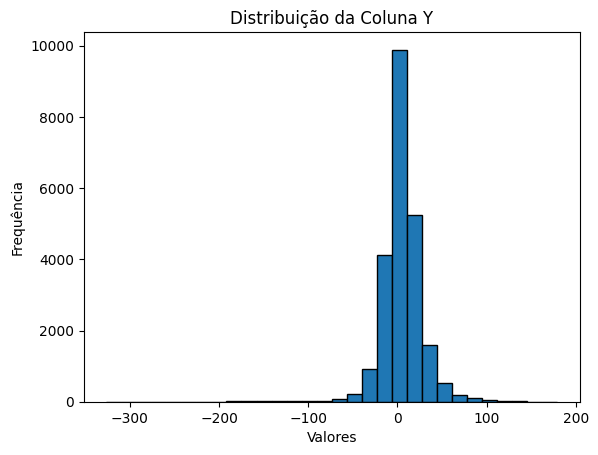

In [ ]:
import matplotlib.pyplot as plt

# Substitua 'nome_da_coluna_Y' pelo nome real da sua coluna Y
coluna_Y = 'Y'

# Crie um gráfico de distribuição
plt.hist(dataset[coluna_Y], bins=30, edgecolor='black')
plt.title('Distribuição da Coluna Y')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

In [ ]:
import pandas as pd

# Seu DataFrame original
data = {
    'Drug1': ['X', 'X', 'Y', 'Y', 'Z', 'Z'],
    'Drug2': ['A', 'A', 'B', 'B', 'C', 'C'],
    'Descritores': [1, 1, 2, 2, 3, 3],
    'cell line': ['a', 'b', 'a', 'b', 'a', 'b'],
    'Y': [1, 2, 3, 1, 2, 3]
}

dataset = pd.DataFrame(data)

# Agrupar por combinação única de drogas e manter listas de valores para "cell line" e "Y"
aggregated_data = dataset.groupby(['Drug1', 'Drug2']).agg({
    'Descritores': 'mean',
    'cell line': list,
    'Y': list
}).reset_index()

# Exibir o DataFrame resultante
print(aggregated_data)



  Drug1 Drug2  Descritores cell line       Y
0     X     A          1.0    [a, b]  [1, 2]
1     Y     B          2.0    [a, b]  [3, 1]
2     Z     C          3.0    [a, b]  [2, 3]
